In [1]:
# =========================
# 1. KẾT NỐI GOOGLE DRIVE
# =========================
from google.colab import drive

# Kết nối với Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

# Đường dẫn tới file zip trong Google Drive
zip_path = '/content/drive/MyDrive/datasets/archive.zip'

# Thư mục giải nén ra
extract_path = '/content/FER_CNN_LSTM/dataset'

# Tạo thư mục nếu chưa có
os.makedirs(extract_path, exist_ok=True)

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Giải nén hoàn tất! Kiểm tra thư mục:", extract_path)


 Giải nén hoàn tất! Kiểm tra thư mục: /content/FER_CNN_LSTM/dataset


In [3]:
# =========================
# 2. CÀI ĐẶT THƯ VIỆN
# =========================
!pip install tensorflow opencv-python matplotlib seaborn

In [4]:
# =========================
# 3. IMPORT THƯ VIỆN
# =========================
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
                                     LSTM, TimeDistributed, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
# =========================
# 4. CẤU HÌNH BAN ĐẦU
# =========================
# Kích thước ảnh đầu vào (giống FER2013: 48x48)
IMG_SIZE = 48

# Số nhãn cảm xúc (giả định theo FER2013: 7 loại cảm xúc)
NUM_CLASSES = 7

# Số lượng frame liên tiếp dùng làm chuỗi đầu vào cho LSTM
NUM_FRAMES = 10

# Định dạng đầu vào cho CNN (1 channel = ảnh xám)
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)

# Định dạng đầu vào cho LSTM (chuỗi ảnh)
SEQ_SHAPE = (NUM_FRAMES, IMG_SIZE, IMG_SIZE, 1)

# Tham số huấn luyện
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001


In [6]:
# =========================
# 5. LOAD DỮ LIỆU
# =========================
def load_data_split(data_path, img_size=48):
    """
    Hàm load ảnh và nhãn từ hai thư mục con: train/ và test/
    Ảnh được resize về kích thước img_size x img_size và chuẩn hóa về [0,1]
    """
    def load_folder(folder):
        images = []
        labels = []
        label_names = sorted(os.listdir(folder))  # Lấy danh sách nhãn (tên folder con)

        for label in label_names:
            img_files = glob.glob(os.path.join(folder, label, '*.jpg'))  # Tìm ảnh trong mỗi thư mục nhãn
            for file in img_files:
                img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)              # Đọc ảnh xám
                img = cv2.resize(img, (img_size, img_size))               # Resize về img_size x img_size
                img = img.astype('float32') / 255.0                       # Chuẩn hóa pixel về [0, 1]
                images.append(img)
                labels.append(label)

        return np.array(images), np.array(labels)

    # Load ảnh từ folder train và test
    X_train, y_train = load_folder(os.path.join(data_path, 'train'))
    X_test, y_test   = load_folder(os.path.join(data_path, 'test'))

    return X_train, y_train, X_test, y_test


# =========================
# GỌI HÀM LOAD DỮ LIỆU
# =========================
dataset_path = '/content/FER_CNN_LSTM/dataset'

X_train, y_train, X_test, y_test = load_data_split(dataset_path, IMG_SIZE)

# =========================
# MÃ HÓA NHÃN (LabelEncoder + One-hot)
# =========================
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded  = label_encoder.transform(y_test)

y_train_cat = to_categorical(y_train_encoded, num_classes=NUM_CLASSES)
y_test_cat  = to_categorical(y_test_encoded, num_classes=NUM_CLASSES)

# =========================
# THÊM KÊNH MÀU CHO ẢNH (vì ảnh xám nên có 1 kênh)
# =========================
X_train = np.expand_dims(X_train, axis=-1)  # shape: (samples, 48, 48, 1)
X_test  = np.expand_dims(X_test, axis=-1)

# =========================
# CHUYỂN THÀNH CHUỖI CHO CNN-LSTM
# =========================
def reshape_to_sequence(X, y, num_frames):
    """
    Cắt dữ liệu để chia hết cho num_frames, rồi reshape thành chuỗi.
    """
    n = (X.shape[0] // num_frames) * num_frames  # số lượng ảnh chia hết cho num_frames
    X = X[:n]
    y = y[:n]

    X_seq = X.reshape((-1, num_frames, IMG_SIZE, IMG_SIZE, 1))      # (batch, time, h, w, c)
    y_seq = y.reshape((-1, num_frames, NUM_CLASSES))                # (batch, time, num_classes)

    y_seq_last = y_seq[:, -1, :]  # lấy nhãn của frame cuối cùng trong chuỗi

    return X_seq, y_seq_last

# Gọi reshape thành chuỗi
X_train_seq, y_train_seq = reshape_to_sequence(X_train, y_train_cat, NUM_FRAMES)
X_test_seq,  y_test_seq  = reshape_to_sequence(X_test, y_test_cat, NUM_FRAMES)


In [7]:
# =========================
# 6. XÂY DỰNG MÔ HÌNH CNN-LSTM
# =========================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
                                     LSTM, TimeDistributed, BatchNormalization)
from tensorflow.keras.optimizers import Adam

# Khởi tạo mô hình tuần tự (Sequential)
model = Sequential()

# ----- BLOCK CNN 1 -----
# TimeDistributed áp dụng Conv2D cho từng frame trong chuỗi
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'),
                          input_shape=(NUM_FRAMES, IMG_SIZE, IMG_SIZE, 1)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))     # Giảm kích thước không gian
model.add(TimeDistributed(BatchNormalization()))     # Chuẩn hóa dữ liệu từng frame
model.add(TimeDistributed(Dropout(0.3)))             # Dropout để giảm overfitting

# ----- BLOCK CNN 2 -----
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Flatten()))                # Chuyển tensor 2D thành vector đặc trưng

# ----- LSTM -----
# Xử lý chuỗi vector đặc trưng theo thời gian
model.add(LSTM(128))           # 128 đơn vị nhớ
model.add(Dropout(0.5))        # Dropout tiếp theo để tránh overfitting

# ----- FULLY CONNECTED (Output) -----
model.add(Dense(NUM_CLASSES, activation='softmax'))  # Softmax để phân loại cảm xúc

# ----- BIÊN DỊCH MÔ HÌNH -----
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),   # Adam với learning rate đã định nghĩa
              loss='categorical_crossentropy',               # Dùng cho phân loại nhiều lớp
              metrics=['accuracy'])                          # Theo dõi độ chính xác trong training

# In cấu trúc mô hình
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 46, 46, 32) │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 23, 23, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 23, 23, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 23, 23, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 21, 21, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 10, 10, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 10, 10, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 10, 6400)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     3,342,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,362,951 (12.83 MB)

 Trainable params: 3,362,759 (12.83 MB)

 Non-trainable params: 192 (768.00 B)

In [8]:
# =========================
# 7. CHUẨN HÓA DỮ LIỆU ĐẦU VÀO DẠNG CHUỖI
# =========================

def reshape_to_sequence(X, y, num_frames):
    """
    Cắt dữ liệu để đảm bảo chia hết cho num_frames,
    sau đó reshape thành dạng chuỗi cho mô hình CNN-LSTM.
    """
    n = (X.shape[0] // num_frames) * num_frames  # Cắt bớt ảnh dư
    X = X[:n]
    y = y[:n]

    # Reshape ảnh thành chuỗi: (số chuỗi, num_frames, 48, 48, 1)
    X_seq = X.reshape((-1, num_frames, IMG_SIZE, IMG_SIZE, 1))

    # Reshape nhãn và lấy nhãn cuối mỗi chuỗi làm đại diện
    y_seq = y.reshape((-1, num_frames, NUM_CLASSES))
    y_seq_last = y_seq[:, -1, :]  # lấy nhãn frame cuối làm nhãn đại diện

    return X_seq, y_seq_last

# Gọi hàm chuẩn hóa chuỗi
X_train_seq, y_train_seq = reshape_to_sequence(X_train, y_train_cat, NUM_FRAMES)
X_test_seq,  y_test_seq  = reshape_to_sequence(X_test, y_test_cat, NUM_FRAMES)

# In kiểm tra shape kết quả
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)


X_train_seq shape: (2870, 10, 48, 48, 1)
y_train_seq shape: (2870, 7)


In [9]:
# =========================
# 8. HUẤN LUYỆN VỚI CALLBACK LƯU MÔ HÌNH MỖI 5 EPOCH
# =========================

from tensorflow.keras.callbacks import ModelCheckpoint

# Đường dẫn lưu mô hình (Google Drive)
checkpoint_dir = '/content/drive/MyDrive/FER_CNN_LSTM/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Callback: Lưu mô hình mỗi 5 epoch
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'),  # Tên file theo epoch
    save_weights_only=False,   # Lưu cả mô hình, không chỉ weights
    save_freq='epoch',         # Lưu theo mỗi epoch, ta kiểm tra bên trong để chỉ giữ lại mỗi 5 epoch nếu muốn
    verbose=1
)

# Callback: Lưu lịch sử huấn luyện (có thể thêm EarlyStopping hoặc ReduceLROnPlateau nếu cần)

# Huấn luyện mô hình
history = model.fit(
    X_train_seq, y_train_seq,                               # Dữ liệu huấn luyện
    validation_data=(X_test_seq, y_test_seq),               # Dữ liệu kiểm thử
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback],                        # Danh sách callback
    verbose=1
)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2520 - loss: 1.8301
Epoch 1: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_01.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 332s 7s/step - accuracy: 0.2535 - loss: 1.8274 - val_accuracy: 0.2469 - val_loss: 2.0245
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5515 - loss: 1.2370
Epoch 2: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_02.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 314s 7s/step - accuracy: 0.5521 - loss: 1.2356 - val_accuracy: 0.5565 - val_loss: 1.1979
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7356 - loss: 0.8302
Epoch 3: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_03.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 334s 7s/step - accuracy: 0.7355 - loss: 0.8299 - val_accuracy: 0.6332 - val_loss: 1.0075
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7896 - loss: 0.5991
Epoch 4: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_04.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 372s 7s/step - accuracy: 0.7898 - loss: 0.5990 - val_accuracy: 0.6695 - val_loss: 0.9478
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8685 - loss: 0.4388
Epoch 5: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_05.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 332s 7s/step - accuracy: 0.8685 - loss: 0.4388 - val_accuracy: 0.7113 - val_loss: 0.7982
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9221 - loss: 0.2894
Epoch 6: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_06.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 369s 7s/step - accuracy: 0.9219 - loss: 0.2897 - val_accuracy: 0.7350 - val_loss: 0.7586
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9508 - loss: 0.2002
Epoch 7: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_07.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 332s 7s/step - accuracy: 0.9506 - loss: 0.2005 - val_accuracy: 0.6681 - val_loss: 1.0230
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9693 - loss: 0.1482
Epoch 8: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_08.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 316s 7s/step - accuracy: 0.9693 - loss: 0.1482 - val_accuracy: 0.7978 - val_loss: 0.5726
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9786 - loss: 0.1043
Epoch 9: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_09.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 332s 7s/step - accuracy: 0.9786 - loss: 0.1043 - val_accuracy: 0.7490 - val_loss: 0.7676
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9906 - loss: 0.0654
Epoch 10: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_10.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 315s 7s/step - accuracy: 0.9906 - loss: 0.0655 - val_accuracy: 0.8201 - val_loss: 0.5160
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9929 - loss: 0.0511
Epoch 11: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_11.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 337s 7s/step - accuracy: 0.9929 - loss: 0.0511 - val_accuracy: 0.8145 - val_loss: 0.5449
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9949 - loss: 0.0387
Epoch 12: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_12.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 378s 7s/step - accuracy: 0.9949 - loss: 0.0388 - val_accuracy: 0.7768 - val_loss: 0.6330
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9968 - loss: 0.0330
Epoch 13: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_13.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 315s 7s/step - accuracy: 0.9968 - loss: 0.0330 - val_accuracy: 0.7657 - val_loss: 0.6804
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9974 - loss: 0.0256
Epoch 14: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_14.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 330s 7s/step - accuracy: 0.9974 - loss: 0.0256 - val_accuracy: 0.8159 - val_loss: 0.5631
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9995 - loss: 0.0153
Epoch 15: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_15.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 371s 7s/step - accuracy: 0.9995 - loss: 0.0153 - val_accuracy: 0.8243 - val_loss: 0.5237
Epoch 16/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9996 - loss: 0.0142
Epoch 16: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_16.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 339s 7s/step - accuracy: 0.9996 - loss: 0.0142 - val_accuracy: 0.8131 - val_loss: 0.5420
Epoch 17/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9991 - loss: 0.0115
Epoch 17: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_17.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 367s 7s/step - accuracy: 0.9991 - loss: 0.0116 - val_accuracy: 0.7936 - val_loss: 0.6852
Epoch 18/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9994 - loss: 0.0131
Epoch 18: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_18.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 333s 7s/step - accuracy: 0.9994 - loss: 0.0130 - val_accuracy: 0.7936 - val_loss: 0.6480
Epoch 19/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9990 - loss: 0.0096
Epoch 19: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_19.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 0.9990 - loss: 0.0096 - val_accuracy: 0.8298 - val_loss: 0.5038
Epoch 20/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0073
Epoch 20: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_20.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 369s 7s/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.8201 - val_loss: 0.5700
Epoch 21/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0066
Epoch 21: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_21.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 330s 7s/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.8061 - val_loss: 0.5867
Epoch 22/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0053
Epoch 22: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_22.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 367s 7s/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.8410 - val_loss: 0.5379
Epoch 23/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0036
Epoch 23: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_23.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 331s 7s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8368 - val_loss: 0.5437
Epoch 24/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0038
Epoch 24: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_24.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 313s 7s/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.8354 - val_loss: 0.5601
Epoch 25/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9993 - loss: 0.0054
Epoch 25: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_25.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 332s 7s/step - accuracy: 0.9993 - loss: 0.0054 - val_accuracy: 0.8047 - val_loss: 0.6138
Epoch 26/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0037
Epoch 26: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_26.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 313s 7s/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.7755 - val_loss: 0.7519
Epoch 27/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0033
Epoch 27: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_27.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 337s 7s/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.7992 - val_loss: 0.6295
Epoch 28/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0025
Epoch 28: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_28.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.8033 - val_loss: 0.6349
Epoch 29/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0027
Epoch 29: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_29.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 390s 7s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.8285 - val_loss: 0.5519
Epoch 30/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0026
Epoch 30: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_30.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 374s 7s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.8145 - val_loss: 0.5750
Epoch 31/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0022
Epoch 31: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_31.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 310s 7s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.8340 - val_loss: 0.5586
Epoch 32/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0020
Epoch 32: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_32.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 334s 7s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8522 - val_loss: 0.5191
Epoch 33/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0021
Epoch 33: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_33.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 308s 7s/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.8229 - val_loss: 0.5853
Epoch 34/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0017
Epoch 34: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_34.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 332s 7s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8340 - val_loss: 0.5674
Epoch 35/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0012
Epoch 35: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_35.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 310s 7s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8298 - val_loss: 0.5568
Epoch 36/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0020
Epoch 36: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_36.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8340 - val_loss: 0.5465
Epoch 37/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0020
Epoch 37: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_37.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 306s 7s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8619 - val_loss: 0.4658
Epoch 38/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0017
Epoch 38: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_38.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8452 - val_loss: 0.5284
Epoch 39/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0012
Epoch 39: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_39.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8271 - val_loss: 0.5984
Epoch 40/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0016
Epoch 40: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_40.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 371s 7s/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8396 - val_loss: 0.5754
Epoch 41/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0013
Epoch 41: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_41.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8382 - val_loss: 0.6092
Epoch 42/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 9.9128e-04
Epoch 42: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_42.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 323s 7s/step - accuracy: 1.0000 - loss: 9.9206e-04 - val_accuracy: 0.8354 - val_loss: 0.6093
Epoch 43/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 7.9340e-04
Epoch 43: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_43.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 309s 7s/step - accuracy: 1.0000 - loss: 7.9366e-04 - val_accuracy: 0.8466 - val_loss: 0.5724
Epoch 44/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0020
Epoch 44: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_44.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 330s 7s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8368 - val_loss: 0.5603
Epoch 45/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 7.9720e-04
Epoch 45: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_45.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 324s 7s/step - accuracy: 1.0000 - loss: 7.9955e-04 - val_accuracy: 0.8452 - val_loss: 0.5183
Epoch 46/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0011
Epoch 46: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_46.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 310s 7s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8452 - val_loss: 0.5616
Epoch 47/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0010
Epoch 47: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_47.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 340s 7s/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8340 - val_loss: 0.5917
Epoch 48/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 7.6893e-04
Epoch 48: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_48.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 377s 7s/step - accuracy: 1.0000 - loss: 7.7148e-04 - val_accuracy: 0.8257 - val_loss: 0.6191
Epoch 49/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 8.9176e-04
Epoch 49: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_49.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step - accuracy: 1.0000 - loss: 8.8967e-04 - val_accuracy: 0.8159 - val_loss: 0.7068
Epoch 50/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 9.8437e-04
Epoch 50: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_50.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 315s 7s/step - accuracy: 1.0000 - loss: 9.7901e-04 - val_accuracy: 0.8298 - val_loss: 0.6291


In [10]:
# =========================
# 9. ĐÁNH GIÁ MÔ HÌNH
# =========================

from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# 9.1 Dự đoán trên tập kiểm thử
# -------------------------
y_pred_probs = model.predict(X_test_seq)                                # Xác suất dự đoán
y_pred_classes = np.argmax(y_pred_probs, axis=1)                        # Lấy nhãn dự đoán (số)
y_true_classes = np.argmax(y_test_seq, axis=1)                          # Lấy nhãn thật (số)

# -------------------------
# 9.2 Báo cáo độ chính xác, Precision, Recall, F1-Score
# -------------------------
print("=== Classification Report ===")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       angry       0.68      0.83      0.75        95
     disgust       0.71      0.45      0.56        11
        fear       0.91      0.58      0.71       103
       happy       0.96      0.98      0.97       177
     neutral       0.95      0.67      0.79       124
         sad       0.66      0.93      0.77       124
    surprise       0.94      0.95      0.95        83

    accuracy                           0.83       717
   macro avg       0.83      0.77      0.78       717
weighted avg       0.86      0.83      0.83       717



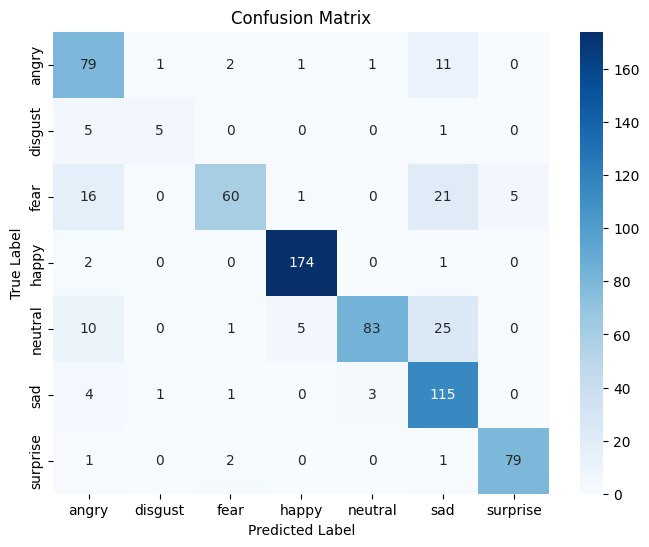

In [11]:
# -------------------------
# 9.3 Ma trận nhầm lẫn
# -------------------------
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


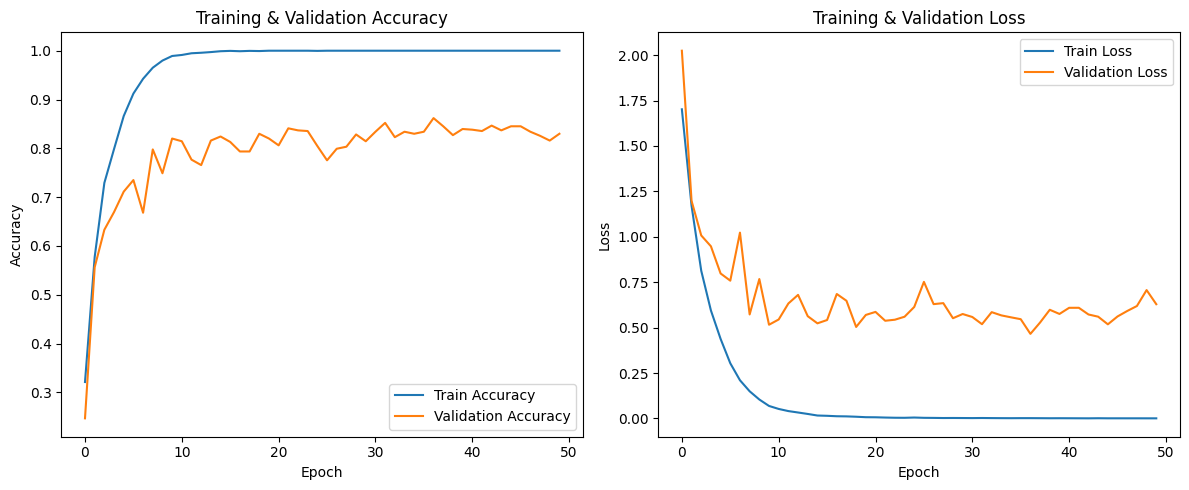

In [12]:
# -------------------------
# 9.4 Learning Curve (Độ chính xác & Độ mất mát)
# -------------------------
plt.figure(figsize=(12, 5))

# Độ chính xác
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Độ mất mát
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# =========================
# 10. LƯU MÔ HÌNH CUỐI CÙNG
# =========================
final_model_path = '/content/drive/MyDrive/FER_CNN_LSTM/model_final_cnn_lstm.h5'
model.save(final_model_path)
print(f" Mô hình đã được lưu tại: {final_model_path}")


 Mô hình đã được lưu tại: /content/drive/MyDrive/FER_CNN_LSTM/model_final_cnn_lstm.h5
